In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Cost of 1gb of Mobile Data per country
cost = pd.read_excel('data\Cost of 1GB of Data.xlsx')

# Adjust some values in the "Country" column to match the iso_codes DataFrame
country_adjusted = {
    'Tanzania' : 'Tanzania, United Republic of',
 'Iran' : 'Iran, Islamic Republic of',
 'Moldova' : 'Moldova, Republic of',
 'Macedonia': 'Macedonia, the former Yugoslav Republic of',
 'Palestine': 'Palestinian Territory, Occupied',
 'Lao PDR' : 'Lao People\'s Democratic Republic',
 'Syria' : 'Syrian Arab Republic',
 'Eswatini' : 'Swaziland'
}
cost['Country'] =  cost['Country'].map(country_adjusted).fillna(cost['Country']).unique()

# Country iso codes lookup
iso_codes = pd.read_csv('data\country_codes_lookup.csv', usecols=['Country', 'Alpha-3 code'])

# GDP per capita per country
header = {'Country Code' : 'Alpha-3 code', '2019' : 'gdp_per_capita'}
gdp = pd.read_excel('data\wb_gdp.xls', 
                    skiprows=3, 
                    usecols=['Country Code', '2019'])
gdp.rename(header, axis=1, inplace=True)

# Join all the DataFrames
merged = cost\
    .merge(iso_codes, on='Country')\
    .merge(gdp, on='Alpha-3 code' )

# Add status columns
merged['status'] = merged['Rank']\
    .apply(lambda x: 'Least expensive' if x <= 11 else 'Most expensive' if x > (merged['Rank'].max() - 10) else 'mid' )

merged.head()

,Rank,Country,Avg Price of 1GB (USD),Alpha-3 code,gdp_per_capita,status
0,1,India,0.09,IND,2099.599048,Least expensive
1,2,Israel,0.11,ISR,43588.713309,Least expensive
2,3,Kyrgyzstan,0.21,KGZ,1309.534960,Least expensive
3,4,Italy,0.43,ITA,33225.648494,Least expensive
4,5,Ukraine,0.46,UKR,3659.031312,Least expensive


## Create plot
---

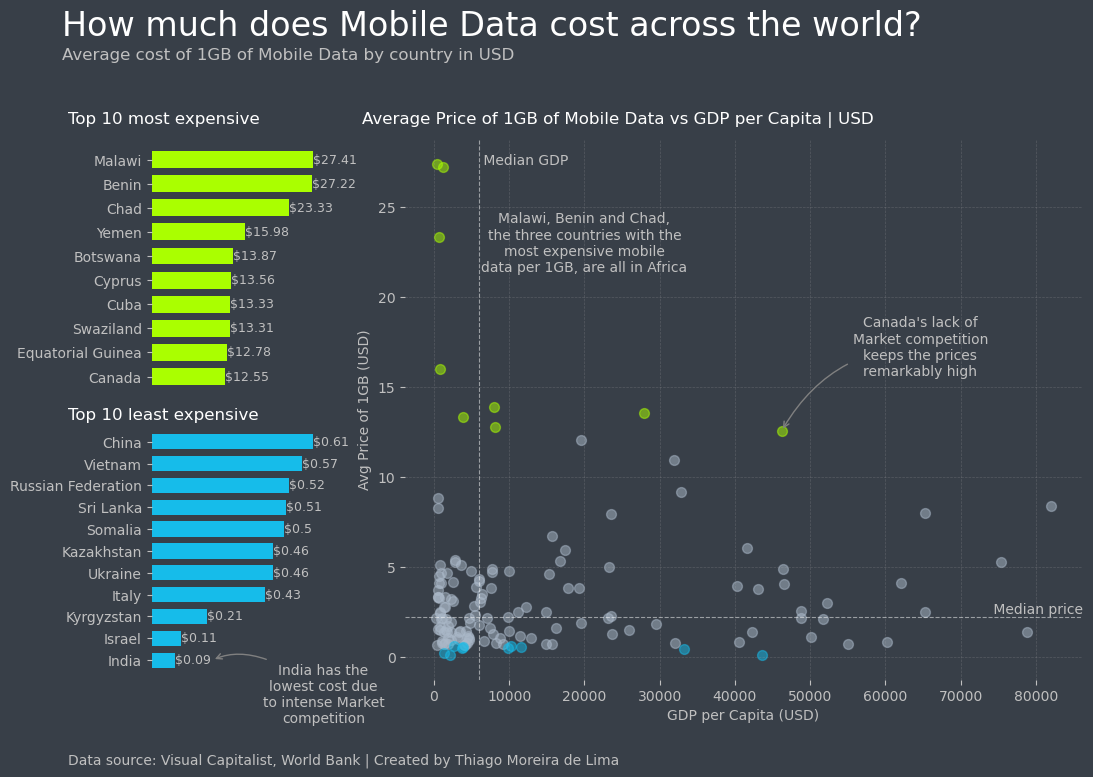

In [3]:
# Set basic defaults
text_color = '#c0c0c0'
rcParams['font.family'] = 'sans-serif'
rcParams['text.color'] = text_color
rcParams['axes.labelcolor'] = text_color
rcParams['xtick.color'] = text_color
rcParams['ytick.color'] = text_color
colors = {'mid' : '#abb9c9', 
          'Most expensive' : '#aaff00',
          'Least expensive' : '#16bcea'
}

# Define layout
fig = plt.figure(figsize = (12,8), dpi=100, facecolor = '#383f48')
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1:])
#ax4 = fig.add_subplot(gs[:1, 3:])


# Top 10 most expensive
most_expensive = merged\
    .loc[merged['status'] == 'Most expensive', :]\
    .sort_values(by='Rank')

for country in most_expensive['Country'].unique():
    view = most_expensive.loc[most_expensive['Country'] == country, :]
    color = colors[view['status'].values[0]]
    y_pos = view['Rank']
    price = view['Avg Price of 1GB (USD)'].values[0]
    ax1.barh(y=y_pos, width=price, height=0.7, color=color)
    ax1.annotate(text=f'${price}', xy=(price, y_pos), va='center', size=9)
    
ax1.set_yticks(most_expensive['Rank'])
ax1.set_yticklabels(most_expensive['Country'])
ax1.set_xticks([])

# Top 10 least expensive
least_expensive = merged\
    .loc[merged['status'] == 'Least expensive', :]\
    .sort_values(by='Rank')

for country in least_expensive['Country'].unique():
    view = least_expensive.loc[least_expensive['Country'] == country, :]
    color = colors[view['status'].values[0]]
    y_pos = view['Rank']
    price = view['Avg Price of 1GB (USD)'].values[0]
    ax2.barh(y=y_pos, width=price, height=0.7, color=color)
    ax2.annotate(text=f'${price}', xy=(price, y_pos), va='center', size=9)
    
ax2.set_yticks(least_expensive['Rank'])
ax2.set_yticklabels(least_expensive['Country'])
ax2.set_xticks([])

# Avg Price vs GDP Scatter
for k, v in colors.items():
    view = merged.loc[merged['status'] == k, :]
    color = colors[k]
    ax3.scatter(view['gdp_per_capita'], view['Avg Price of 1GB (USD)'],
                s=50,
                color = color,
                edgecolors = color,
                alpha=0.5)
price_med, gdp_med = merged['Avg Price of 1GB (USD)'].median(), merged['gdp_per_capita'].median()
ax3.axhline(y=price_med, color='w', linewidth=0.8, linestyle='--', alpha=0.5)
ax3.annotate(text=f' Median GDP', xy=(gdp_med,  merged['Avg Price of 1GB (USD)'].max()))
ax3.axvline(x=gdp_med, color='w', linewidth=0.8, linestyle='--', alpha=0.5) 
ax3.annotate(text=f' Median price', xy=(merged['gdp_per_capita'].max() * 0.9,  price_med), va='bottom')   
ax3.grid(True, linewidth=0.5, linestyle='--', alpha=0.25) # Add gridlines
ax3.set_xlabel('GDP per Capita (USD)')   
ax3.set_ylabel('Avg Price of 1GB (USD)')    

    
# Annotations 
# Overall title and subtitle
fig.text(x =0.05, y= 0.93, s = 'How much does Mobile Data cost across the world?', size=24, color='w')
fig.text(x =0.05, y= 0.9, s = 'Average cost of 1GB of Mobile Data by country in USD', size=12)

# Subplot titles
fig.text(x =0.055, y= 0.82, s = 'Top 10 most expensive', size=12, color='w' ) # Top 5 most expensive
fig.text(x =0.055, y= 0.45, s = 'Top 10 least expensive', size=12, color='w') # Top 5 least expensive
fig.text(x =0.3, y= 0.82, s = 'Average Price of 1GB of Mobile Data vs GDP per Capita | USD', size=12, color='w') # Scatter

# Highlights
ax2.annotate(text='India has the\nlowest cost due\nto intense Market\ncompetition',
            xy=(0.23, 1), xycoords='data', ha='center', xytext=(80, -45), textcoords='offset points',
            arrowprops={'arrowstyle' : "->", 'color' : '#808080', 'connectionstyle' : "angle3,angleA=-40, angleB=25"})

ax3.annotate(text='Malawi, Benin and Chad,\nthe three countries with the\nmost expensive mobile\ndata per 1GB, are ' +
            'all in Africa',xy=(20000, 23), ha='center', va='center')

ax3.annotate(text="Canada's lack of\nMarket competition\nkeeps the prices\nremarkably high" ,
            xy=(46189, 12.55), xycoords='data', ha='center', xytext=(100, 40), textcoords='offset points',
            arrowprops={'arrowstyle' : "->", 'color' : '#808080', 'connectionstyle' : "angle3,angleA=0,angleB=-120"})

# Footnote
footnote = fig.text(s='Data source: Visual Capitalist, World Bank | ' + 
                    'Created by Thiago Moreira de Lima', 
                    ha='left', x=0.055, y=0.02, size=10)   


# Clean up
for ax in fig.get_axes():
    ax.patch.set_alpha(0)
    for spine in ax.spines: # Remove borders
        ax.spines[spine].set_visible(False)
fig.subplots_adjust(top=0.8, wspace=0.5, hspace=0.1)

# Save as png
fig.savefig('cost_of_mobile_data_plot.png', facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')